# GANs - I’m Something of a Painter Myself

## Description of the problem/data

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

This project task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

## Importing libraries

In [1]:
# Numerical and Data Handling
import numpy as np
import pandas as pd
from collections import Counter

# Image Processing and Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras import layers

# Utility Libraries
import time
import zipfile
import io
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import random
from tqdm import tqdm

E0000 00:00:1755668157.386285      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


## Exploratory Data Analysis (EDA) procedure

The dataset is organized into four directories: two dedicated to Monet-style paintings and two containing photographic images. Files are available in both JPEG and TFRecord formats. The Monet directories hold a total of 300 images, each with dimensions of 256 by 256 pixels. In contrast, the photo directories contain 7,038 images, also sized at 256 by 256 pixels.

In [2]:
def count_images_in_directory(directory_path):
    return sum(
        1 for filename in os.listdir(directory_path)
        if os.path.isfile(os.path.join(directory_path, filename))
    )

def display_image_info(image_path, label):
    with Image.open(image_path) as img:
        print(f"{label} image size: {img.width} x {img.height}")

# Monet images
monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
monet_count = count_images_in_directory(monet_dir)
print(f"Monet count: {monet_count}")
display_image_info(os.path.join(monet_dir, '000c1e3bff.jpg'), "Monet")

# Photo images
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'
photo_count = count_images_in_directory(photo_dir)
print(f"Photo count: {photo_count}")
display_image_info(os.path.join(photo_dir, '00068bc07f.jpg'), "Photo")

Monet count: 300
Monet image size: 256 x 256
Photo count: 7038
Photo image size: 256 x 256


To conduct exploratory data analysis (EDA), I focused on identifying any potential inconsistencies or issues within the Monet and photo directories.
- I confirmed the image counts: 300 Monet images and 7,038 photo images.
- I visually inspected a sample of images to understand the dataset's contents.
- I verified that all images across both directories share the same dimensions—256 by 256 pixels.
- I ensured that none of the images were corrupted.
Since these checks revealed no problems, I decided not to make any changes to the image data.


Image counts: {'Monet': 300, 'Photo': 7038}


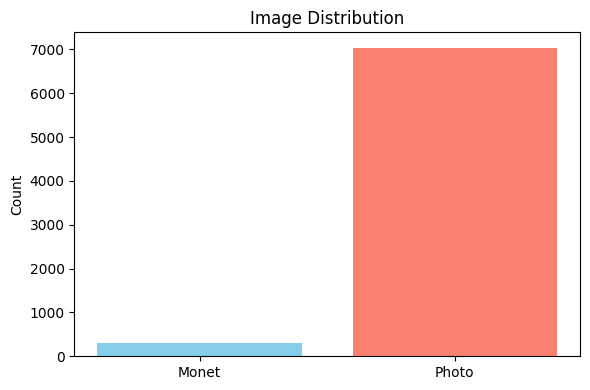

In [3]:
def get_image_counts(*directories):
    return [len(os.listdir(path)) for path in directories]

def plot_image_distribution(labels, counts, title="Image Distribution", ylabel="Count"):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color=["skyblue", "salmon"])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Define paths and labels
monet_dir = monet_dir
photo_dir = photo_dir
labels = ["Monet", "Photo"]

# Get counts and plot
image_counts = get_image_counts(monet_dir, photo_dir)
print(f"Image counts: {dict(zip(labels, image_counts))}")
plot_image_distribution(labels, image_counts)

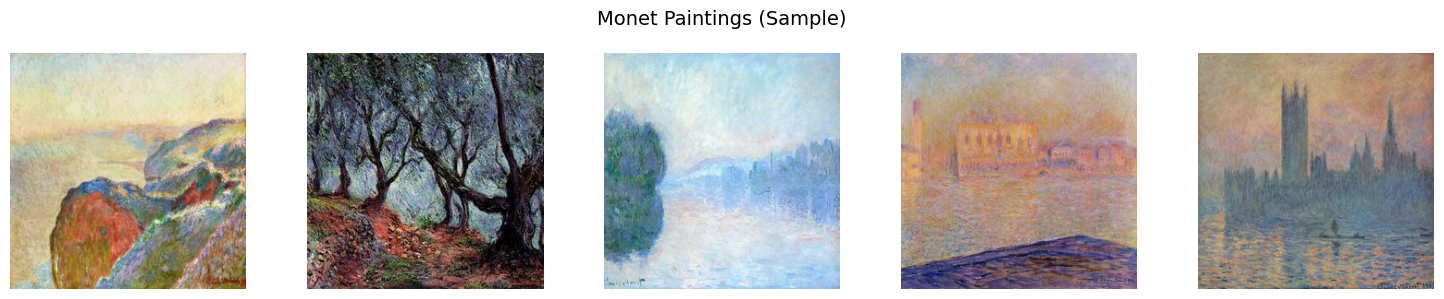

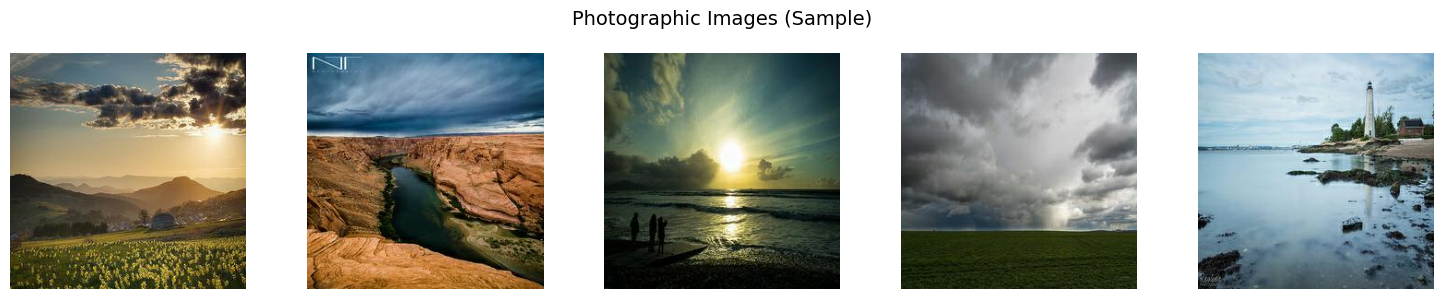

In [4]:
def display_sample_images(directory, title, num_samples=5, image_size=(15, 3)):
    sample_files = sorted(os.listdir(directory))[:num_samples]
    fig, axes = plt.subplots(1, num_samples, figsize=image_size)

    for ax, filename in zip(axes, sample_files):
        image_path = os.path.join(directory, filename)
        with Image.open(image_path) as img:
            ax.imshow(img)
            ax.axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Display samples
display_sample_images(monet_dir, "Monet Paintings (Sample)")
display_sample_images(photo_dir, "Photographic Images (Sample)")

In [5]:
def collect_image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        try:
            with Image.open(image_path) as img:
                sizes.append(img.size)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    return sizes

# Gather image dimensions
monet_sizes = collect_image_sizes(monet_dir)
photo_sizes = collect_image_sizes(photo_dir)

# Display most frequent dimensions
print("Top Monet image sizes:", Counter(monet_sizes).most_common(3))
print("Top Photo image sizes:", Counter(photo_sizes).most_common(3))

Top Monet image sizes: [((256, 256), 300)]
Top Photo image sizes: [((256, 256), 7038)]


In [6]:
def find_corrupt_images(directory):
    corrupt_files = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        try:
            with Image.open(image_path) as img:
                img.verify()
        except Exception:
            corrupt_files.append(filename)
    return corrupt_files

# Check for corrupt Monet images
corrupt_monet = find_corrupt_images(monet_dir)
if corrupt_monet:
    print("Corrupt Monet images:", corrupt_monet)
else:
    print("No corrupt Monet images found.")

# Check for corrupt Photo images
corrupt_photo = find_corrupt_images(photo_dir)
if corrupt_photo:
    print("Corrupt Photo images:", corrupt_photo)
else:
    print("No corrupt Photo images found.")

No corrupt Monet images found.
No corrupt Photo images found.


## Analysis (Model building and training)

As part of this initiative, I’m implementing a Generative Adversarial Network (GAN), which consists of two interconnected neural networks working in opposition. The first network, known as the generator, transforms photographic images into Monet-style artwork. The second network, the discriminator, evaluates these outputs by attempting to distinguish between authentic Monet paintings and those generated by the model.
Throughout training, the generator strives to produce increasingly convincing images that can deceive the discriminator, while the discriminator simultaneously improves its ability to detect synthetic art. This adversarial process drives both networks to refine their capabilities, resulting in progressively more realistic artistic transformations.

### Generator Structure Overview

The generator is a convolutional neural network built to transform standard photos into Monet-style artwork. Its architecture follows an encoder-decoder design, inspired by U-Net or ResNet structures.
Core components include:

- Convolutional layers for extracting visual features.
- Residual blocks that maintain image content while applying stylistic changes.
- Upsampling layers that restore the original resolution after downsampling.
  
The final output is an image with the same dimensions as the input, but rendered in the style of Monet.

### Discriminator Structure Overview

The discriminator is a convolutional neural network (CNN) designed for binary classification. It takes an input image—either a real Monet painting or one generated by the model—and outputs a grid of predictions indicating whether each image patch is authentic or synthetic. This patch-level evaluation follows the PatchGAN approach, allowing the model to focus on local texture and style consistency rather than the overall image structure.

### Generator Network

In [7]:
def residual_block(input_tensor, num_filters):
    """Defines a residual block with two convolutional layers."""
    shortcut = input_tensor

    x = layers.Conv2D(num_filters, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return layers.add([shortcut, x])

def build_generator(image_size=256):
    """Constructs the generator model with encoder, residual blocks, and decoder."""
    input_layer = layers.Input(shape=(image_size, image_size, 3))

    # Encoder
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    for _ in range(3):
        x = residual_block(x, 256)

    # Decoder
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output Layer
    output_layer = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(x)

    return tf.keras.Model(input_layer, output_layer, name="Generator")

# Instantiate and summarize the generator
generator = build_generator()
generator.summary()

I0000 00:00:1755668254.811171      10 service.cc:148] XLA service 0x5569d0dce2c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755668254.811237      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1755668254.811241      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1755668254.811244      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1755668254.811247      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1755668254.811251      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1755668254.811253      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1755668254.811256      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1755668254.811258      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ re_lu_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    590,080 │ re_lu_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ re_lu_2[0][0],    │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ add[0][0]       

 Total params: 4,305,923 (16.43 MB)

 Trainable params: 4,301,571 (16.41 MB)

 Non-trainable params: 4,352 (17.00 KB)

### Discriminator Network

In [8]:
def build_discriminator(image_size=256):
    """Constructs the discriminator model using a PatchGAN-style CNN."""
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    input_layer = layers.Input(shape=(image_size, image_size, 3), name="input_image")

    # Layer 1: No normalization in the first layer
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same',
                      kernel_initializer=initializer)(input_layer)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Layer 2
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Layer 3
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Layer 4
    x = layers.Conv2D(512, kernel_size=4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Output Layer: Patch-level prediction
    output_layer = layers.Conv2D(1, kernel_size=4, strides=1, padding='same',
                                 kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name="Discriminator")

# Instantiate and summarize the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Data Ingestion for GAN Training

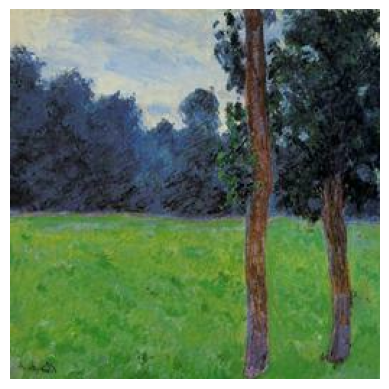

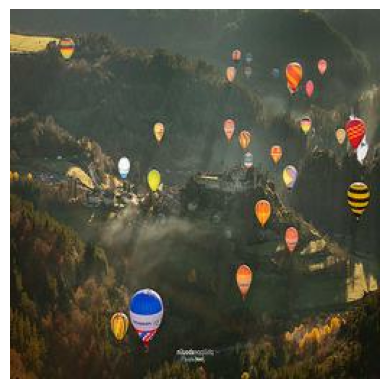

In [9]:
# Constants
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256
BATCH_SIZE = 4  # Adjust based on available memory

def normalize_image(image):
    """Normalizes image pixels to [-1, 1] range."""
    return (image / 127.5) - 1

def load_image(file_path):
    """Reads and decodes a JPEG image from file."""
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return normalize_image(image)

def load_image_with_augmentation(file_path):
    """Loads and applies random horizontal flip to image."""
    image = load_image(file_path)
    image = tf.image.random_flip_left_right(image)
    return image

def prepare_dataset(file_pattern, augment_fn, shuffle_buffer=1000):
    """Creates a preprocessed and batched dataset from file pattern."""
    dataset = tf.data.Dataset.list_files(file_pattern, shuffle=True)
    dataset = dataset.map(augment_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache().shuffle(shuffle_buffer).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Build datasets
monet_ds = prepare_dataset(monet_dir + '/*.jpg', load_image_with_augmentation)
photo_ds = prepare_dataset(photo_dir + '/*.jpg', load_image_with_augmentation)

def show_sample(dataset):
    """Displays a single image from the dataset after de-normalizing."""
    for batch in dataset.take(1):
        image = (batch[0] + 1) / 2  # Convert back to [0, 1] for display
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Visual check
show_sample(monet_ds)
show_sample(photo_ds)

### Model Training

In [11]:
# Least Squares GAN loss functions
mse = tf.keras.losses.MeanSquaredError()

def compute_generator_loss(fake_scores):
    return mse(tf.ones_like(fake_scores), fake_scores)

def compute_discriminator_loss(real_scores, fake_scores):
    real_loss = mse(tf.ones_like(real_scores), real_scores)
    fake_loss = mse(tf.zeros_like(fake_scores), fake_scores)
    return 0.5 * (real_loss + fake_loss)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Training step
@tf.function
def perform_training_step(photo_batch, monet_batch):
    with tf.GradientTape(persistent=True) as tape:
        generated_batch = generator(photo_batch, training=True)

        real_output = discriminator(monet_batch, training=True)
        fake_output = discriminator(generated_batch, training=True)

        gen_loss = compute_generator_loss(fake_output)
        disc_loss = compute_discriminator_loss(real_output, fake_output)

    gen_grads = tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Display utilities
def show_image(img_tensor):
    img_tensor = (img_tensor + 1) / 2  # Convert from [-1, 1] to [0, 1]
    plt.imshow(img_tensor)
    plt.axis('off')
    plt.show()

def show_generated_batch(epoch_index, input_batch):
    predictions = generator(input_batch, training=False)
    for i in range(predictions.shape[0]):
        show_image(predictions[i])

# Training configuration
num_epochs = 5
sample_batch = tf.random.normal([4, 256, 256, 3])  # Batch of 4 for visualization

for ep in range(num_epochs):
    start_time = time.time()

    for photo_data, monet_data in tf.data.Dataset.zip((photo_ds, monet_ds)):
        gen_loss, disc_loss = perform_training_step(photo_data, monet_data)

    elapsed = time.time() - start_time
    print(f"Epoch {ep+1}/{num_epochs} | Gen Loss: {gen_loss:.4f} | Disc Loss: {disc_loss:.4f} | Time: {elapsed:.2f}s")

Epoch 1/5 | Gen Loss: 0.2870 | Disc Loss: 0.2521 | Time: 175.78s
Epoch 2/5 | Gen Loss: 0.5893 | Disc Loss: 0.4986 | Time: 164.33s
Epoch 3/5 | Gen Loss: 0.3173 | Disc Loss: 0.2629 | Time: 163.30s
Epoch 4/5 | Gen Loss: 0.2733 | Disc Loss: 0.2772 | Time: 164.48s
Epoch 5/5 | Gen Loss: 0.2623 | Disc Loss: 0.2475 | Time: 164.15s


## Result Breakdown and Discussion

### Monet-Style Image Generation

In [12]:
# Define input/output paths and configuration
PHOTO_DIR = '/kaggle/input/gan-getting-started/photo_jpg'
ZIP_OUTPUT_PATH = '/kaggle/working/images.zip'
TARGET_IMAGE_COUNT = 7038
IMAGE_SIZE = (256, 256)

# Load and sort photo filenames, limit to target count
photo_files = sorted(os.listdir(PHOTO_DIR))[:TARGET_IMAGE_COUNT]

def preprocess_image(path):
    """Load image from disk, decode JPEG, resize, and normalize to [-1, 1]."""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return (image / 127.5) - 1

def denormalize_image(tensor):
    """Convert image tensor from [-1, 1] back to uint8 [0, 255] format."""
    image = (tensor + 1) * 127.5
    image = tf.clip_by_value(image, 0, 255)
    return tf.cast(image, tf.uint8).numpy()

def write_image_to_zip(image_array, filename, zip_handle):
    """Encode image as JPEG and write to zip archive in memory."""
    pil_image = Image.fromarray(image_array)
    buffer = io.BytesIO()
    pil_image.save(buffer, format='JPEG')
    zip_handle.writestr(filename, buffer.getvalue())

def generate_and_zip_images(generator_model, photo_paths, zip_path):
    """Run inference on input images, generate Monet-style outputs, and save to zip."""
    zipf = zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED)
    for i, filename in enumerate(tqdm(photo_paths)):
        full_path = os.path.join(PHOTO_DIR, filename)

        # Preprocess input image and add batch dimension
        input_image = preprocess_image(full_path)
        input_batch = tf.expand_dims(input_image, axis=0)

        # Generate stylized image using trained generator
        generated_image = generator_model(input_batch, training=False)[0]

        # Convert output to uint8 and save to zip
        output_array = denormalize_image(generated_image)
        write_image_to_zip(output_array, f'image_{i+1}.jpg', zipf)

    zipf.close()

# Execute generation and packaging
generate_and_zip_images(generator, photo_files, ZIP_OUTPUT_PATH)
print("Image generation and packaging complete.")

100%|██████████| 7038/7038 [14:25<00:00,  8.13it/s]


Image generation and packaging complete.


### Monet-Style Image Display

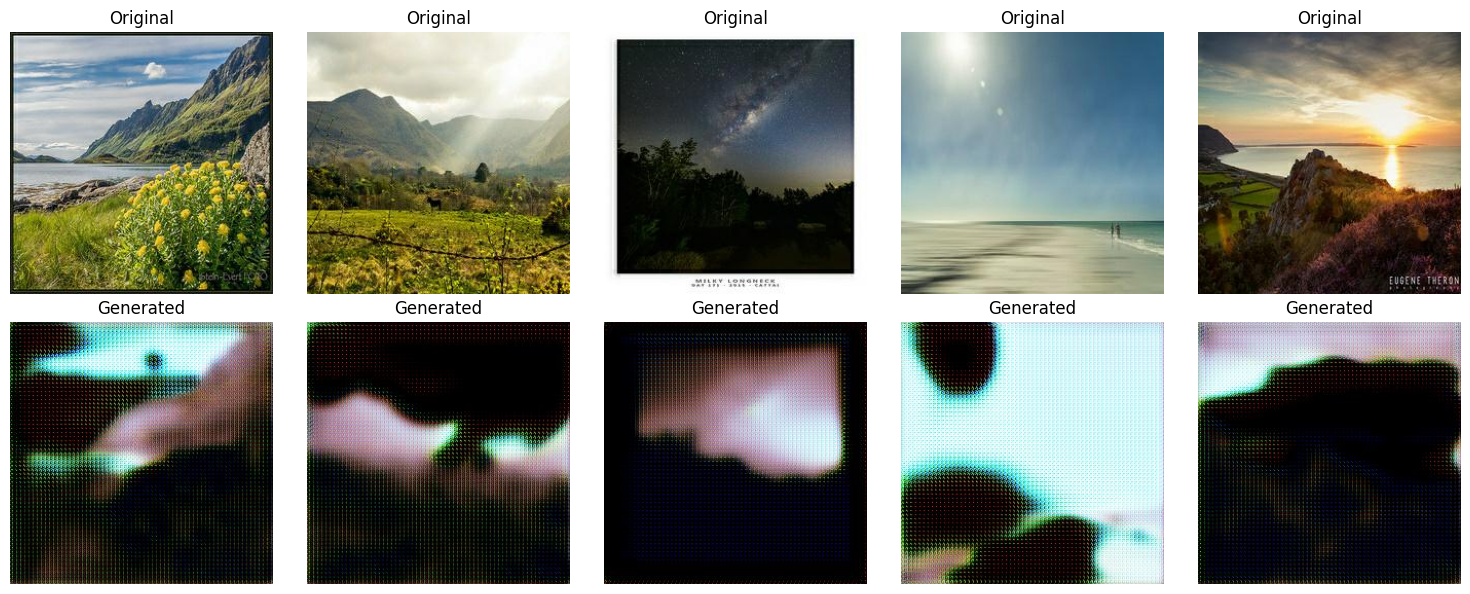

In [13]:
# Define paths
PHOTO_DIR = '/kaggle/input/gan-getting-started/photo_jpg'
ZIP_PATH = '/kaggle/working/images.zip'
MAX_IMAGES = 7038
SAMPLE_COUNT = 5
IMAGE_SIZE = (256, 256)

# Load and sort photo filenames to align with generated image order
photo_files = sorted(os.listdir(PHOTO_DIR))
num_samples = min(len(photo_files), MAX_IMAGES)

# Randomly select sample indices for visualization
sample_indices = random.sample(range(num_samples), SAMPLE_COUNT)

# Open zip archive and prepare plot
with zipfile.ZipFile(ZIP_PATH, 'r') as zipf:
    fig, axes = plt.subplots(2, SAMPLE_COUNT, figsize=(15, 6))

    for i, idx in enumerate(sample_indices):
        # Load and resize original photo
        photo_path = os.path.join(PHOTO_DIR, photo_files[idx])
        photo_img = Image.open(photo_path).resize(IMAGE_SIZE)

        # Load and resize generated Monet-style image from zip
        gen_filename = f'image_{idx+1}.jpg'
        with zipf.open(gen_filename) as f:
            monet_img = Image.open(f).resize(IMAGE_SIZE).convert('RGB')

        # Display original photo (top row)
        axes[0, i].imshow(photo_img)
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Display generated image (bottom row)
        axes[1, i].imshow(monet_img)
        axes[1, i].set_title("Generated")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

### Insights and Technical Hurdles
One of the earliest bottlenecks I faced was the training runtime. Running the model on a CPU proved impractical. Epoch durations were prohibitively long, making meaningful experimentation nearly impossible. Switching to a TPU VM v3-8 drastically improved throughput, bringing epoch times down to under 176 seconds.

With the accelerator in place, I explored several adjustments to the GAN architecture and tuning parameters. Due to time constraints, I didn’t conduct a full grid or random search; instead, I iteratively modified the code to test specific ideas. These included adding an extra layer to the generator and increasing the number of filters. However, these changes didn’t yield noticeable improvements in the visual fidelity of the Monet-style outputs.


## Discussion and Conclusion

I expected that increasing the number of layers and filters in the generator would improve image quality, but the results didn’t support that assumption. The generated Monet-style images looked similar to earlier outputs, suggesting that simply adding complexity to the architecture wasn’t enough to enhance visual fidelity.
For future development, I’d consider a few targeted improvements. Adjusting the learning rates for both the generator and discriminator could help stabilize training and reduce divergence, which might lead to faster convergence and more consistent results. Another idea is to apply batch normalization after each layer. This could help regulate activation distributions and improve overall training behavior.

Due to limited time, I didn’t run a full hyperparameter search. Instead, I manually tested a few changes to get a sense of their impact. If I revisit this, I’d take a more structured approach to tuning and architectural adjustments to better understand what drives meaningful improvements.

## GitHub repository

https://github.com/k-khuu/GANS-monet